In [1]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json
import tensorflow as tf

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
#%matplotlib inline
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)


In [76]:
import rl_model
importlib.reload(rl_model)

#import fitting

initial_state_expt_file = os.path.join(git_dir, 'data', '189228-expt.json')
final_state_expt_file = os.path.join(git_dir, 'data', '189237-expt.json')

data_file = os.path.join(git_dir, 'data', 'r189236-time-resolved.json')

with open(data_file) as fd:
    m = json.load(fd)
    timestamps = np.asarray(m['times'])
    _data = m['data']
    print("Number of times: %s" % len(_data))
    

REVERSE = True
  
# create an instance of our custom environment
env = rl_model.SLDEnv(initial_state_file=initial_state_expt_file,
                      final_state_file=final_state_expt_file,
                      data=_data, reverse=REVERSE)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()

print(type(env.action_space))
#reward: -2.262466851785423
#[ 0.09542739  0.45447298 -0.6012057 ]

Number of times: 25
<class 'numpy.ndarray'>
0
<class 'gymnasium.spaces.box.Box'>


reward: -3.220361100490868
[-0.27628032  0.30918931  0.46417551]


<IPython.core.display.Javascript object>


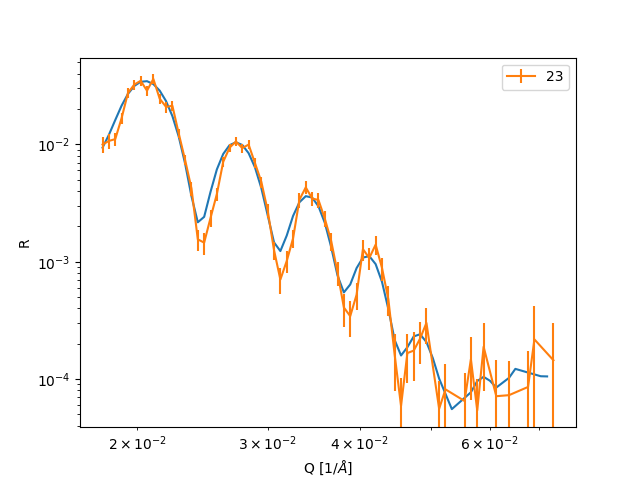

In [77]:
terminated = False

#while not terminated: 
for i in range(1):
    #time.sleep(1)

    # choose a random action
    if False:
        action = env.action_space.sample() 
    else:
        action = env.normalized_parameters

    # take the action and get the information from the environment
    new_state, reward, terminated, truncated, info = env.step(action)
    print("reward: %s" % reward)
    # show the current position and reward
    env.render(action=action, reward=reward) 
    env.plot(errors=True)

In [83]:
%%time

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback(
    save_freq=1000,
    save_path="./logs-01-to-06-forward/",
    name_prefix="rl_model-forward",
    save_replay_buffer=False,
    save_vecnormalize=True,
)

model = SAC('MlpPolicy', env, use_sde=False, verbose=0)

if True:
    model.learn(500000, callback=checkpoint_callback)
    model.save('UIUC-01-to-06-SAC-backward')
else:
    model = SAC.load("cell-b-CV1-30-SAC")

CPU times: user 58min 14s, sys: 1h 36min 45s, total: 2h 34min 59s
Wall time: 1h 11min 56s


# Compute uncertainties

In [84]:
deltas = env.high_array - env.low_array

samples = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(len(env.data)):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)


samples = np.asarray(samples).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)

(3, 25, 100)
(3, 25)


In [85]:
# Evaluate the agent

episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

actions = []
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    new_obs, reward, terminated, truncated, info = env.step(action)  
    episode_reward += reward
    print("Time %s %s: %g [%s] %g" % (timestamps[i], obs, reward, terminated, episode_reward))
    obs = new_obs


actions = np.asarray(actions)

Number of times: 25
Time 0 [1.]: -3.21889 [False] -3.21889
Time 60 [0.9583333]: -1.58667 [False] -4.80555
Time 120 [0.9166667]: -2.00343 [False] -6.80899
Time 180 [0.875]: -2.08829 [False] -8.89728
Time 240 [0.8333333]: -1.52405 [False] -10.4213
Time 300 [0.7916667]: -2.12106 [False] -12.5424
Time 360 [0.75]: -1.69474 [False] -14.2371
Time 420 [0.7083333]: -1.772 [False] -16.0091
Time 480 [0.6666667]: -1.69997 [False] -17.7091
Time 540 [0.625]: -1.89016 [False] -19.5993
Time 600 [0.5833333]: -2.69841 [False] -22.2977
Time 660 [0.5416667]: -4.33778 [False] -26.6354
Time 720 [0.5]: -6.02935 [False] -32.6648
Time 780 [0.45833334]: -8.11829 [False] -40.7831
Time 840 [0.41666666]: -10.7571 [False] -51.5402
Time 900 [0.375]: -15.1732 [False] -66.7134
Time 960 [0.33333334]: -16.5794 [False] -83.2928
Time 1020 [0.29166666]: -7.47229 [False] -90.7651
Time 1080 [0.25]: -5.61792 [False] -96.3831
Time 1140 [0.20833333]: -3.56143 [False] -99.9445
Time 1200 [0.16666667]: -1.71295 [False] -101.657
Ti

['solvent interface', 'PVF thickness', 'PVF rho']


<IPython.core.display.Javascript object>


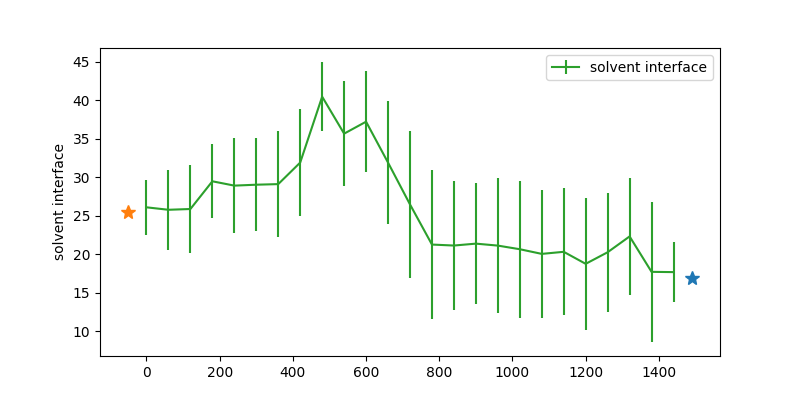

<IPython.core.display.Javascript object>


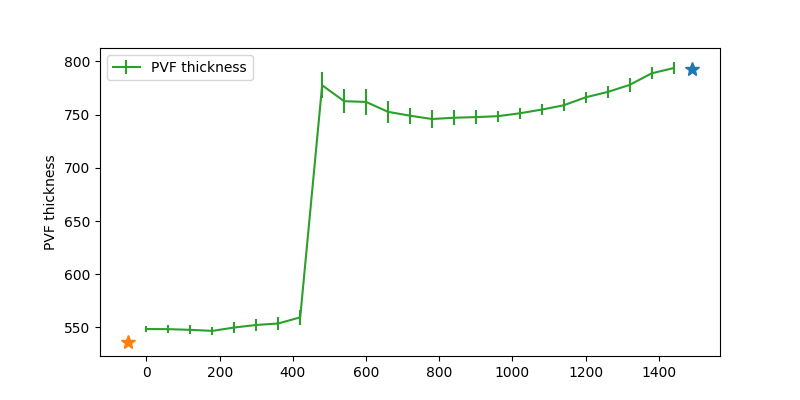

<IPython.core.display.Javascript object>


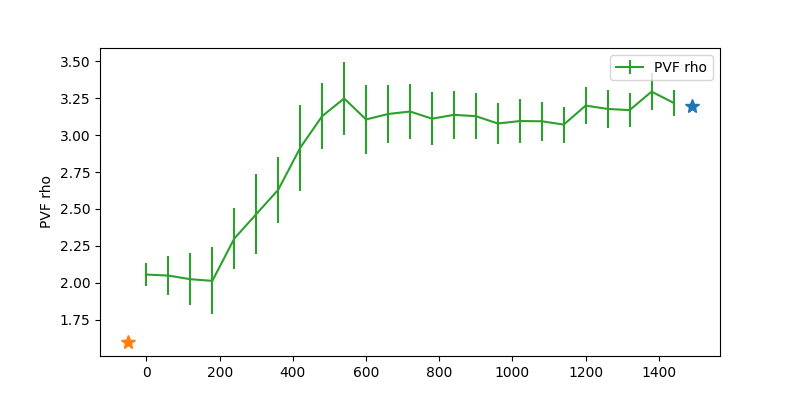

In [86]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T
errors = errs.T

# Bayesian fit trend
#with open( '/Users/m2d/git/vae-sld/data/time-resolved/cell_b/trend-201289.json') as fd:
#    bayes_fits = json.load(fd)

if REVERSE:
    t_initial = timestamps[-1]+50
    t_final = -50
    _times = np.flip(timestamps)
else:
    t_final = timestamps[-1]+50
    t_initial = -50
    _times = timestamps

n_times = len(env.data)

print(env.par_labels)
for i in range(pars.shape[0]):
    fig = plt.subplots(dpi=100, figsize=(8, 4))
    #plt.plot(times, pars[i], label=env.par_labels[i])
    plt.plot([t_initial,], [env.parameters[i]], linestyle='', marker='*', markersize=10)
    if env.end_model is not None:
        plt.plot([t_final,], [env.end_parameters[i]], linestyle='', marker='*', markersize=10)
    plt.errorbar(_times, pars[i], yerr=errs[i], label=env.par_labels[i])
    
    #plt.errorbar(bayes_fits[0], bayes_fits[1][env.par_labels[i]], yerr=bayes_fits[2][env.par_labels[i]], label='Bayesian fit')
    plt.ylabel(env.par_labels[i])
    plt.legend()

Number of times: 25


<IPython.core.display.Javascript object>


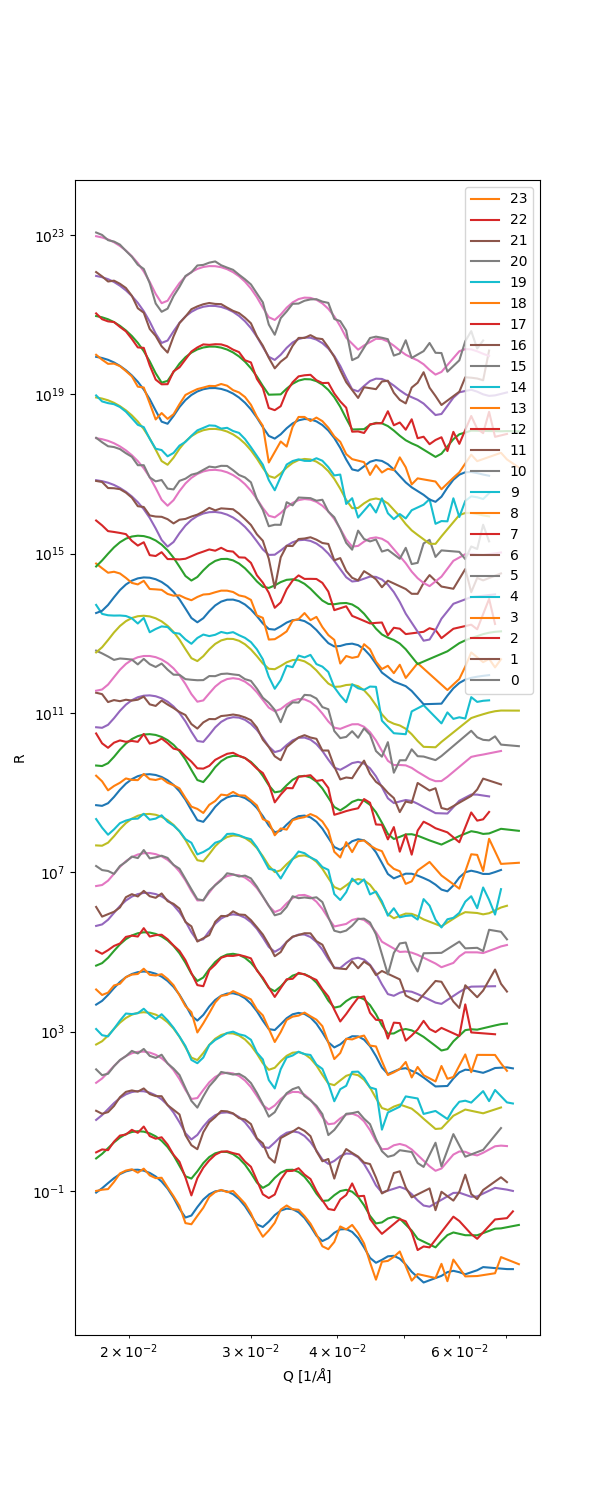

In [87]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig = plt.subplots(dpi=100, figsize=(6, 15))
for i in range(1, n_times, 1):
    action, _ = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = env.step(action)

    env.plot(scale=10.**i, newfig=False)
